# 📊 Predict Future Sales
## A Machine Learning Approach

This notebook explores a sales prediction problem using machine learning. It covers data preprocessing, feature engineering, model training, and evaluation. The dataset comes from a Kaggle competition, and the goal is to predict total sales for a product in a specific shop for the next month.

### Steps Covered:

- Feature Engineering 🔍
- Model Training 🤖
- Evaluation & Predictions 📈


In [ ]:
# # !pip install pandas holidays
# # !pip install optuna
# !pip install fbprophet
# !pip install tensorflow --upgrade
# !pip install keras


In [3]:
import pandas as pd
import numpy as np
import holidays
from datetime import datetime
import matplotlib.pyplot as plt
# import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import itertools
import prophet


from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, LSTM,Dropout,RepeatVector,TimeDistributed,Flatten


## 📂 Data Loading & Exploration

Let's start by loading the dataset and exploring its structure.

In [8]:
df_items=pd.read_csv('items.csv')
df_item_categories=pd.read_csv('item_categories.csv')
df_sales_train=pd.read_csv('sales_train.csv')
df_sample_submission=pd.read_csv('sample_submission.csv')
df_shops=pd.read_csv('shops.csv')
df_test=pd.read_csv('test.csv')

# df_all_features=pd.read_csv(output_csv)

### EDA

In [ ]:
df_sales_train['date_'] = pd.to_datetime(df_sales_train['date'],format='%d.%m.%Y')
df_sales_train['year']=df_sales_train['date_'].dt.year
df_sales_train['month']=df_sales_train['date_'].dt.month
df_sales_train['day_of_week'] = df_sales_train['date_'].dt.dayofweek
df_sales_train['is_weekend'] = df_sales_train['day_of_week'].isin([5, 6]).astype(int)
df_sales_train['item_avg_price'] = df_sales_train.groupby('item_id')['item_price'].transform('mean')


<Figure size 1000x600 with 0 Axes>

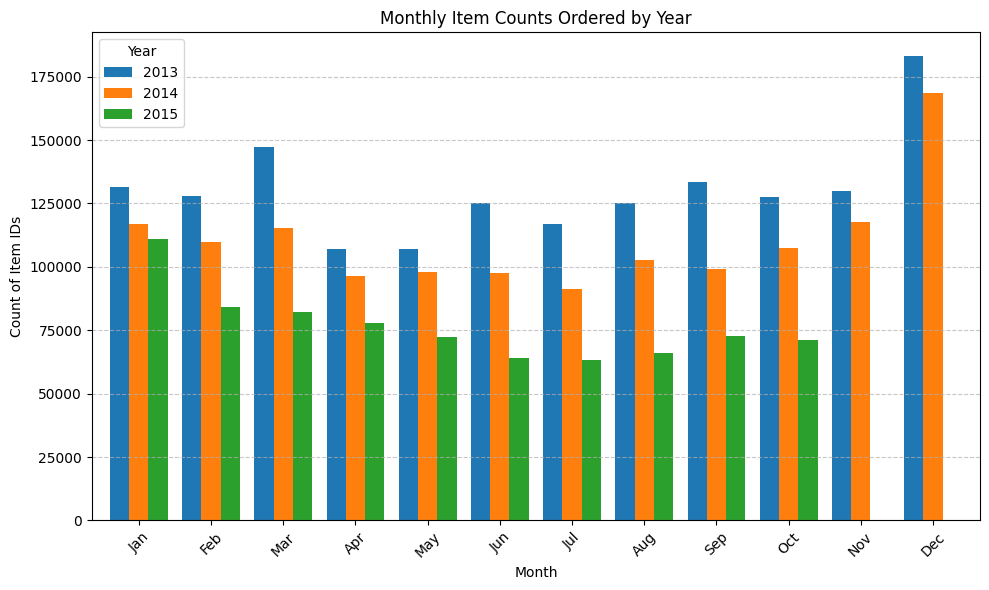

In [11]:

grouped_data = df_sales_train.groupby(['year', 'month'])['item_cnt_day'].sum().reset_index(name='count')

pivot_data = grouped_data.pivot(index='month', columns='year', values='count')

plt.figure(figsize=(10, 6))
pivot_data.plot(kind='bar', figsize=(10, 6), width=0.8)
plt.title('Monthly Item Counts Ordered by Year')
plt.xlabel('Month')
plt.ylabel('Count of Item IDs')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.legend(title='Year')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## 🔍 Feature Engineering

Creating meaningful features to improve model performance.

In [ ]:

df_train = df_sales_train.pivot_table(index=['shop_id', 'item_id'],
                                      values=['item_cnt_day'],
                                      columns=['date_block_num'],
                                      fill_value=0,
                                      aggfunc='sum')
df_train_ = df_train.reset_index()

df_train_.head(5)

shop_id item_id item_cnt_day                                 \
date_block_num                            0     1    2    3    4    5    6   
0                    0      30          0.0  31.0  0.0  0.0  0.0  0.0  0.0   
1                    0      31          0.0  11.0  0.0  0.0  0.0  0.0  0.0   
2                    0      32          6.0  10.0  0.0  0.0  0.0  0.0  0.0   
3                    0      33          3.0   3.0  0.0  0.0  0.0  0.0  0.0   
4                    0      35          1.0  14.0  0.0  0.0  0.0  0.0  0.0   

                     ...                                                    
date_block_num    7  ...   24   25   26   27   28   29   30   31   32   33  
0               0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1               0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2               0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3               0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4               0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 36 columns]

In [ ]:
df_train_.columns=[''.join(map(str,col)).strip() if isinstance(col, tuple) else col for col in df_train_.columns]

In [ ]:
dataset = pd.merge(df_test, df_train_, on=['item_id', 'shop_id'], how='left')
dataset.fillna(0, inplace=True)

In [ ]:
dataset.drop(['ID','shop_id','item_id'],inplace=True,axis=1)

## 🤖 Model Training

Building and training machine learning models.

In [ ]:
X_train = np.expand_dims(dataset.values[:, :-1], axis=2)
y_train = dataset.values[:, -1:]
X_test = dataset.values[:, 1:]


In [ ]:

model_lstm = Sequential()
model_lstm.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.4))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error'])
model_lstm.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

## 📈 Evaluation & Predictions

Assessing model performance and making future sales predictions.

In [ ]:
history_lstm=model_lstm.fit(X_train,y_train,batch_size=4096,epochs=10)

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - loss: 111.3502 - mean_squared_error: 111.3502
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - loss: 22.8110 - mean_squared_error: 22.8110
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 90.3210 - mean_squared_error: 90.3210
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - loss: 31.3674 - mean_squared_error: 31.3674
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - loss: 21.0451 - mean_squared_error: 21.0451
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 25.8582 - mean_squared_error: 25.8582
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 87.6189 - mean_squared_error: 87.6189
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 48.4861 - mean_squared_error: 48.4861
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 56.1726 - mean_squared_error: 56.1726
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - loss: 12.9455 - mean_squared_error: 12.9455


In [ ]:
history_lstm.history['loss']

[30.566747665405273,
 30.24319076538086,
 30.098960876464844,
 29.95218276977539,
 29.89641761779785,
 29.739469528198242,
 29.710603713989258,
 29.689464569091797,
 29.605623245239258,
 29.62103843688965]

<ipython-input-43-d9ba74edaf32>:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


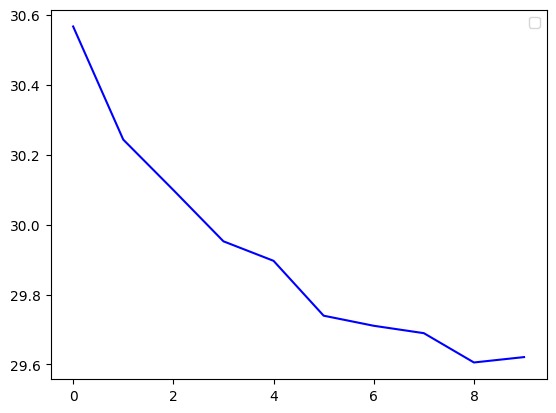

In [ ]:
plt.plot(history_lstm.history['loss'],color='b')
plt.legend()

In [ ]:
y_pred=model_lstm.predict(X_test)
y_pred_=y_pred.clip(0,20)


6694/6694 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step


In [ ]:
sbm = pd.DataFrame({'ID': df_test['ID'], 'item_cnt_month': y_pred_.ravel().round().astype(int)})
sbm

,ID,item_cnt_month
0,0,0
1,1,0
2,2,1
3,3,0
4,4,0
...,...,...
214195,214195,0
214196,214196,0
214197,214197,0
214198,214198,0


In [ ]:
sbm.to_csv('submit.csv')